# EEG and Behavioral Data Integration Pipeline for Joint Modeling

## Method Overview

This script integrates **preprocessed EEG data** (in BIDS format) with **trial-level behavioral responses** to generate a unified dataset for joint modeling. It extracts **multiverse neural features**—including trial-wise and bins-level ERP. For each level analysis, we calculate **amplitude (AMS, PAMS) and build-up rate (SLPS)**. These features are then merged with behavioral variables (e.g., reaction time, accuracy) on a **trial-by-trial basis**, normalized within subjects, and structured for joint modeling.

---

# Code Walkthrough: EEG–Behavior Integration and Feature Engineering
This script processes data from 20 subjects to extract trial-level neural features, align them with behavior, and prepare a clean, analysis-ready dataset. Below is a step-by-step explanation of the code flow.


## 1. **Configuration and Directory Setup**

- Key directories are defined:
  - `PREPROCESSED_DATA_ROOT`: Path to BIDS-formatted EEG data (after preprocessing).
  - `PROJECT_ROOT`: Base project directory.
  - Three subdirectories under `results/` are created:
    - `epoch/`: Stores raw epoched EEG data (in volts).
    - `erp/`: Stores channel-reduced ERP matrices.
    - `joint-modeling/`: Stores the final merged dataset.
- **Time windows** are specified relative to the **response event** (t = 0):
  - `ERP_TMIN = –1.0`, `ERP_TMAX = 0.2`: Full window for ERP visualization and quality control.
  - `T_AMS_SLPS = [–0.18, –0.08]`: Pre-response window for preparatory activity.
  - `T_PAMS = [–0.05, 0.05]`: Peri-response window for motor peak detection.
- **ROI channel indices** `[54, 36, 86]` are selected to focus analysis on a functionally relevant scalp region.

---

## 2. **Load and Validate Behavioral Data**

- The behavioral file (`behaviorData_low_1_final.csv`) is loaded into a pandas DataFrame.
- It is assumed that the **first column contains subject IDs** in the format `'A001'`, `'A002'`, etc.
- A quick summary prints the number of trials and columns to confirm successful loading.

---

## 3. **Subject-Level Processing Loop**

For each of the 20 subjects (`sub-A001` to `sub-A020`):

### a. **Extract subject-specific behavioral trials**
- Filter `behavior_df` to include only rows matching the current subject (e.g., `'A001'`).
- Assert that at least one trial exists; otherwise, raise an error.

### b. **Load EEG data and extract response events**
- The EEG file (`.vhdr`) is loaded using `mne.io.read_raw_brainvision`.
- MNE’s annotation system parses event markers; the **response event** is identified as `'Stimulus/S  5'`.
- **Critical validation**: The number of EEG response events **must exactly match** the number of behavioral trials. If not, the script halts with an assertion error—ensuring no misalignment.

### c. **Epoch full ERP window**
- EEG data is epoched from **–1.0 s to +0.2 s** relative to response onset.
- The resulting `Epochs` object is validated to ensure trial count integrity.
- Raw epoched data (converted from µV to V) is saved as a `.mat` file for potential re-use.

### d. **Compute group ERP for visualization**
- ERP is computed by averaging across the three ROI channels and all trials.
- This per-subject average ERP is appended to a list (`erp_across_subjects`) for later group-level plotting.

### e. **Extract trial-level neural features**

#### i. **AMS (Average Motor Signal)**
- Epochs data in the **pre-response window** (–180 to –80 ms).
- For each trial, average across ROI channels and time → yields a single **AMS value per trial**.

#### ii. **PAMS (Peak Amplitude of Motor Signal)**
- Epochs data in the **peri-response window** (–50 to +50 ms).
- For each trial, take the **maximum amplitude** across time (after averaging channels) → **PAMS per trial**.

#### iii. **SLPS (Slope of Preparatory Signal)**
- Same pre-response window as AMS.
- For each trial:
  1. Average across ROI channels → 1D time series.
  2. Apply a **smoothing function** (`smooth()`) to reduce noise.
  3. Fit a **linear regression** (slope = SLPS) over the smoothed segment.
- This captures the **rate of neural buildup** before response.

### f. **Merge neural features with behavior**
- A DataFrame `features_df` contains `ams`, `pams`, `slps` (one row per trial).
- It is concatenated with the subject’s behavioral data.
- A `subj` column is added for downstream grouping.
- This combined DataFrame is appended to `joint_modeling_dfs`.

---

## 4. **Aggregate and Normalize Across Subjects**

After processing all subjects:

### a. **Combine all trials into one DataFrame**
- `pd.concat(joint_modeling_dfs)` creates `joint_full` with one row per trial (~20 subjects × hundreds of trials).

### b. **Subject-level quantile binning (on original values)**
- For each neural feature (`ams`, `pams`, `slps`), trials are grouped by subject and split into **4 quantile bins** (1st to 4th quartile).
- A safety check ensures binning only occurs if sufficient variability exists; otherwise, `'N/A'` is assigned.

### c. **Within-subject z-scoring (on original values)**
- Each feature is **standardized per subject**:  
  `z = (x – mean) / std`
- This removes subject-specific offsets, making features comparable across individuals—critical for pooling data in linear models.

### d. **Compute bin means of z-scored features**
- For each subject and quantile bin, the **mean z-score** is computed.
- This mean is **broadcast back to every trial** in that bin, creating new columns (`ams_bin`, `pams_bin`, `slp_bin`).
- Enables analyses comparing behavioral outcomes across **neural bins** (e.g., “Do trials in the top SLPS bin have faster RTs?”).

---

## 5. **Final Output and Validation**

- The final DataFrame `joint_full` is saved as `joint_modeling_all.csv`.
- A summary prints total trial count and number of unique subjects.
- **Final check**: Confirms that all 20 expected subjects are present.

---

## 6. **ERP Visualization Helper**

- The `plot_erp_results()` function is defined to visualize **group-average ERP** with **±SEM shading**.
- It assumes input `erp` is shape `(n_subjects, n_timepoints)`.
- **Note**: The call at the bottom (`plot_erp_results(test_plot, ...)`) appears to be a **debug artifact**—`test_plot` is not defined in the pipeline and should be removed or guarded in production.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy

import mne 
import mne_bids

from smooth import *

In [ ]:
# =============================================================================
# Configuration: Paths and Parameters
# =============================================================================

PREPROCESSED_DATA_ROOT = '../data/preprocessData'
PROJECT_ROOT = '..'

RESULTS_DIR_EPOCH = os.path.join(PROJECT_ROOT, 'results', 'epoch')
RESULTS_DIR_ERP = os.path.join(PROJECT_ROOT, 'results', 'erp')
RESULTS_DIR_JOINT = os.path.join(PROJECT_ROOT, 'results', 'joint-modeling')

os.makedirs(RESULTS_DIR_EPOCH, exist_ok=True)
os.makedirs(RESULTS_DIR_ERP, exist_ok=True)
os.makedirs(RESULTS_DIR_JOINT, exist_ok=True)

BIDS_TASK_LABEL = '_task-randomDot'
BIDS_MODALITY_SUFFIX = '_eeg'

SAMPLING_RATE = 500
CHANNEL_INDICES = [54, 36, 86]

ERP_TMIN, ERP_TMAX = -1.0, 0.2
T_AMS_SLPS_START, T_AMS_SLPS_END = -0.18, -0.08
T_PAMS_START, T_PAMS_END = -0.05, 0.05


In [41]:
# =============================================================================
# Load and Validate Behavioral Data
# =============================================================================

BEHAVIORAL_DATA_PATH = '../data/behaviorData_low_1_final.csv'
assert os.path.exists(BEHAVIORAL_DATA_PATH), f"Behavioral data file not found: {BEHAVIORAL_DATA_PATH}"

behavior_df = pd.read_csv(BEHAVIORAL_DATA_PATH)
print(f"Loaded behavioral data with {behavior_df.shape[0]} rows and {behavior_df.shape[1]} columns.")


Loaded behavioral data with 5701 rows and 5 columns.


In [ ]:
# =============================================================================
# Process Each Subject with Embedded Validation
# =============================================================================

SUBJECT_CODES = [f'sub-A{i:03d}' for i in range(1, 21)]
BEHAVIOR_SUBJECT_IDS = [f'A{i:03d}' for i in range(1, 21)]

erp_across_subjects = []
joint_modeling_dfs = []

for sub_id, beh_sub_id in zip(SUBJECT_CODES, BEHAVIOR_SUBJECT_IDS):
    print(f"\nProcessing subject: {beh_sub_id}")

    # ---------------------------------------------------------
    # 1. Behavioral data for current subject
    # ---------------------------------------------------------
    subject_behavior = behavior_df[behavior_df.iloc[:, 0] == beh_sub_id].reset_index(drop=True)
    n_behavior_trials = len(subject_behavior)
    print(f"  - Behavioral trials: {n_behavior_trials}")
    assert n_behavior_trials > 0, f"No behavioral data found for subject {beh_sub_id}"

    # ---------------------------------------------------------
    # 2. Load EEG file and validate existence
    # ---------------------------------------------------------
    eeg_vhdr_path = os.path.join(
        PREPROCESSED_DATA_ROOT,
        sub_id,
        'eeg',
        f"{sub_id}{BIDS_TASK_LABEL}{BIDS_MODALITY_SUFFIX}.vhdr"
    )
    assert os.path.exists(eeg_vhdr_path), f"EEG file not found: {eeg_vhdr_path}"

    raw = mne.io.read_raw_brainvision(eeg_vhdr_path, preload=False)
    events, event_id = mne.events_from_annotations(raw)

    # Validate that response event exists
    response_event_key = 'Stimulus/S  5'
    assert response_event_key in event_id, f"Response event '{response_event_key}' not found in annotations for {sub_id}"
    response_event_id = {response_event_key: event_id[response_event_key]}
    response_events = events[events[:, 2] == response_event_id[response_event_key]]

    n_eeg_trials = len(response_events)
    print(f"  - EEG response-locked trials: {n_eeg_trials}")

    assert n_eeg_trials == n_behavior_trials, "Trial count mismatch! EEG: {n_eeg_trials}, Behavior: {n_behavior_trials}"

    # ---------------------------------------------------------
    # 4. Full ERP epoching
    # ---------------------------------------------------------
    epochs_full = mne.Epochs(
        raw, response_events, event_id=response_event_id,
        tmin=ERP_TMIN, tmax=ERP_TMAX,
        baseline=None, preload=True
    )
    assert epochs_full.get_data().shape[0] == n_eeg_trials, "Epoch count mismatch after epoching"

    # Save epoched data (convert µV → V)
    epochs_data_v = epochs_full.get_data()
    assert not np.isnan(epochs_data_v).all(), "All EEG data is NaN — check preprocessing pipeline"
    scipy.io.savemat(os.path.join(RESULTS_DIR_EPOCH, f'epoch_{sub_id}.mat'), {'EEG_epoch': epochs_data_v})

    # Extract ERP
    erp_data = epochs_full.get_data(picks=CHANNEL_INDICES)
    assert erp_data.shape[1] == len(CHANNEL_INDICES), "Channel selection failed"
    erp_avg = np.nanmean(erp_data, axis=(0, 1))
    erp_across_subjects.append(erp_avg)

    scipy.io.savemat(os.path.join(RESULTS_DIR_ERP, f'erp_{sub_id}.mat'), {'erp': erp_data})

    # ---------------------------------------------------------
    # 5. Feature extraction: AMS, PAMS, SLPS
    # ---------------------------------------------------------

    # AMS & SLPS window
    epochs_ams_slps = mne.Epochs(
        raw, response_events, event_id=response_event_id,
        tmin=T_AMS_SLPS_START, tmax=T_AMS_SLPS_END,
        baseline=None, preload=True
    )
    data_ams_slps = epochs_ams_slps.get_data(picks=CHANNEL_INDICES)
    data_ams_slps_avg = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)

    # PAMS window
    epochs_pams = mne.Epochs(
        raw, response_events, event_id=response_event_id,
        tmin=T_PAMS_START, tmax=T_PAMS_END,
        baseline=None, preload=True
    )
    data_pams = epochs_pams.get_data(picks=CHANNEL_INDICES)
    data_pams_avg = np.nanmean(data_pams, axis=1)

    # SLPS: smoothing and slope
    slps_df = pd.DataFrame(data_ams_slps_avg)
    slps_smoothed = smooth(slps_df, sample_rate=SAMPLING_RATE)

    # Validate smoothing output shape
    assert slps_smoothed.shape == slps_df.shape, "Smoothing altered data shape"

    ams = np.nanmean(data_ams_slps_avg, axis=1)
    pams = np.nanmax(data_pams_avg, axis=1)

    n_trials = data_ams_slps_avg.shape[0]
    slps = np.empty(n_trials)
    time_vector = np.arange(slps_smoothed.shape[1]) / SAMPLING_RATE
    for i in range(n_trials):
        y = slps_smoothed.iloc[i, :]
        slope = np.polyfit(time_vector, y, deg=1)[0]        
        slps[i] = slope
            
    # Final validation: no all-NaN features
    assert not np.all(np.isnan(ams)), "All AMS values are NaN"
    assert not np.all(np.isnan(pams)), "All PAMS values are NaN"
    assert not np.all(np.isnan(slps)), "All SLPS values are NaN"

    features_df = pd.DataFrame({
        'ams': ams,
        'pams': pams,
        'slps': slps
    })

    # Final trial count check
    assert len(features_df) == n_behavior_trials, "Feature extraction altered trial count"

    # Merge with behavior
    joint_df = pd.concat([features_df, subject_behavior], axis=1)
    joint_df['subj'] = beh_sub_id
    joint_modeling_dfs.append(joint_df)


# =============================================================================
# Aggregate and Finalize with Group-Level Validation
# =============================================================================

joint_full = pd.concat(joint_modeling_dfs, ignore_index=True)
print(f"\nAggregated dataset: {joint_full.shape[0]} trials across {joint_full['subj'].nunique()} subjects.")



Processing subject: A001
  - Behavioral trials: 279
Extracting parameters from ../data/preprocessData/sub-A001/eeg/sub-A001_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
  - EEG response-locked trials: 279
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated
Loading data for 279 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated
Loading data for 279 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
279 matching events found
No baseline correction applied
0 projection items activated
Loading data for 279 events and 51 original time points ...
0 bad epochs dropped

Processing subject: A002

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:82: RuntimeWarning: Mean of empty slice
  data_ams_slps_avg = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)


0 bad epochs dropped
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Loading data for 280 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Loading data for 280 events and 51 original time points ...
0 bad epochs dropped

Processing subject: A006
  - Behavioral trials: 306
Extracting parameters from ../data/preprocessData/sub-A006/eeg/sub-A006_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
  - EEG response-locked trials: 306
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Loading data for 306 events and 601 original time points ...
0 bad epochs dropped
Not 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:82: RuntimeWarning: Mean of empty slice
  data_ams_slps_avg = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:91: RuntimeWarning: Mean of empty slice
  data_pams_avg = np.nanmean(data_pams, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:101: RuntimeWarning: Mean of empty slice
  ams = np.nanmean(data_ams_slps_avg, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:102: RuntimeWarning: All-NaN slice encountered
  pams = np.nanmax(data_pams_avg, axis=1)


0 bad epochs dropped
Not setting metadata
293 matching events found
No baseline correction applied
0 projection items activated
Loading data for 293 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
293 matching events found
No baseline correction applied
0 projection items activated
Loading data for 293 events and 51 original time points ...
0 bad epochs dropped

Processing subject: A008
  - Behavioral trials: 318
Extracting parameters from ../data/preprocessData/sub-A008/eeg/sub-A008_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
  - EEG response-locked trials: 318
Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated
Loading data for 318 events and 601 original time points ...


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:82: RuntimeWarning: Mean of empty slice
  data_ams_slps_avg = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:91: RuntimeWarning: Mean of empty slice
  data_pams_avg = np.nanmean(data_pams, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:101: RuntimeWarning: Mean of empty slice
  ams = np.nanmean(data_ams_slps_avg, axis=1)


0 bad epochs dropped
Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated
Loading data for 318 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated
Loading data for 318 events and 51 original time points ...
0 bad epochs dropped

Processing subject: A009
  - Behavioral trials: 216
Extracting parameters from ../data/preprocessData/sub-A009/eeg/sub-A009_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
  - EEG response-locked trials: 216
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Loading data for 216 events and 601 original time points ...


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:82: RuntimeWarning: Mean of empty slice
  data_ams_slps_avg = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:91: RuntimeWarning: Mean of empty slice
  data_pams_avg = np.nanmean(data_pams, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:101: RuntimeWarning: Mean of empty slice
  ams = np.nanmean(data_ams_slps_avg, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:102: RuntimeWarning: All-NaN slice encountered
  pams = np.nanmax(data_pams_avg, axis=1)


0 bad epochs dropped
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Loading data for 216 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Loading data for 216 events and 51 original time points ...
0 bad epochs dropped

Processing subject: A010
  - Behavioral trials: 257
Extracting parameters from ../data/preprocessData/sub-A010/eeg/sub-A010_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
  - EEG response-locked trials: 257
Not setting metadata
257 matching events found
No baseline correction applied
0 projection items activated
Loading data for 257 events and 601 original time points ...


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:82: RuntimeWarning: Mean of empty slice
  data_ams_slps_avg = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:91: RuntimeWarning: Mean of empty slice
  data_pams_avg = np.nanmean(data_pams, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:102: RuntimeWarning: All-NaN slice encountered
  pams = np.nanmax(data_pams_avg, axis=1)


0 bad epochs dropped
Not setting metadata
257 matching events found
No baseline correction applied
0 projection items activated
Loading data for 257 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
257 matching events found
No baseline correction applied
0 projection items activated
Loading data for 257 events and 51 original time points ...
0 bad epochs dropped

Processing subject: A011
  - Behavioral trials: 312
Extracting parameters from ../data/preprocessData/sub-A011/eeg/sub-A011_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
  - EEG response-locked trials: 312
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 601 original time points ...
0 bad epochs dropped
Not 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:82: RuntimeWarning: Mean of empty slice
  data_ams_slps_avg = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:91: RuntimeWarning: Mean of empty slice
  data_pams_avg = np.nanmean(data_pams, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:101: RuntimeWarning: Mean of empty slice
  ams = np.nanmean(data_ams_slps_avg, axis=1)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:102: RuntimeWarning: All-NaN slice encountered
  pams = np.nanmax(data_pams_avg, axis=1)


0 bad epochs dropped
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 51 original time points ...
0 bad epochs dropped

Processing subject: A014
  - Behavioral trials: 310
Extracting parameters from ../data/preprocessData/sub-A014/eeg/sub-A014_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
  - EEG response-locked trials: 310
Not setting metadata
310 matching events found
No baseline correction applied
0 projection items activated
Loading data for 310 events and 601 original time points ...


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:82: RuntimeWarning: Mean of empty slice
  data_ams_slps_avg = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)


0 bad epochs dropped
Not setting metadata
310 matching events found
No baseline correction applied
0 projection items activated
Loading data for 310 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
310 matching events found
No baseline correction applied
0 projection items activated
Loading data for 310 events and 51 original time points ...
0 bad epochs dropped

Processing subject: A015
  - Behavioral trials: 299
Extracting parameters from ../data/preprocessData/sub-A015/eeg/sub-A015_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
  - EEG response-locked trials: 299
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Loading data for 299 events and 601 original time points ...
0 bad epochs dropped
Not 

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:82: RuntimeWarning: Mean of empty slice
  data_ams_slps_avg = np.nanmean(data_ams_slps, axis=1)  # (n_trials, n_times)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/287859305.py:91: RuntimeWarning: Mean of empty slice
  data_pams_avg = np.nanmean(data_pams, axis=1)


0 bad epochs dropped
Not setting metadata
274 matching events found
No baseline correction applied
0 projection items activated
Loading data for 274 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
274 matching events found
No baseline correction applied
0 projection items activated
Loading data for 274 events and 51 original time points ...
0 bad epochs dropped

Aggregated dataset: 5701 trials across 20 subjects.


In [43]:
# =============================================================================
# Analysis for joint modeling
# =============================================================================

# Validate subject IDs
expected_subs = set(BEHAVIOR_SUBJECT_IDS)
actual_subs = set(joint_full['subj'].unique())
assert actual_subs == expected_subs, f"Subject ID mismatch: missing {expected_subs - actual_subs}"

# Step 1: Quantile binning based on ORIGINAL values
for feature in ['ams', 'pams', 'slps']:
    quantile_col = f"{feature}_quantile"
    
    def safe_qcut_original(x):
        # x is the ORIGINAL feature values
        x_clean = x.dropna()
        if x_clean.nunique() < 4:
            return pd.Series(['N/A'] * len(x), index=x.index)
        try:
            return pd.qcut(x, q=4, labels=['1st', '2nd', '3rd', '4th'])
        except Exception:
            return pd.Series(['N/A'] * len(x), index=x.index)
    
    joint_full[quantile_col] = joint_full.groupby('subj')[feature].transform(safe_qcut_original)

# Step 2: Convert ORIGINAL values to z-scores (now feature column becomes z-scored)
for feature in ['ams', 'pams', 'slps']:
    def safe_zscore(x):
        x_clean = x.dropna()
        if len(x_clean) < 2:
            return pd.Series(np.nan, index=x.index)
        return (x - x.mean()) / x.std()
    joint_full[feature] = joint_full.groupby('subj')[feature].transform(safe_zscore)

# Step 3: Compute bin means of the Z-SCORED values
for feature in ['ams', 'pams', 'slps']:
    quantile_col = f"{feature}_quantile"
    bin_col = 'slp_bin' if feature == 'slps' else f"{feature[:2]}_bin"
    
    # Group by subject and quantile, take mean of z-scored feature
    bin_means = joint_full.groupby(['subj', quantile_col])[feature].mean().reset_index()
    bin_means.rename(columns={feature: bin_col}, inplace=True)
    
    # Merge back: each trial gets the mean z-score of its bin
    joint_full = pd.merge(joint_full, bin_means, on=['subj', quantile_col], how='left')

# Save
output_path = os.path.join(RESULTS_DIR_JOINT, 'joint_modeling_all.csv')
joint_full.to_csv(output_path, index=False)
print(f"\n✅ Processing completed successfully. Output saved to:\n{output_path}")


✅ Processing completed successfully. Output saved to:
../results/joint-modeling/joint_modeling_all.csv


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/4289328660.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = joint_full.groupby(['subj', quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/4289328660.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = joint_full.groupby(['subj', quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_29243/4289328660.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future versio

# Plot
The following codes aim to plot response-locked CPP data in the rang of [-1, 0.2]

In [44]:
def plot_erp_results(erp, times, ylim=[-10, 10], labelpad=0):

    """
    参数：
        erp: shape为[n_subs, n_times]的矩阵，对应每个被试的ERP
        times: shape为[n_times]的array，代表时间点（对应x轴的时间范围及时间点）
        ylim：Y轴范围，默认[-10, 10]
        labelpad：Y轴标签离坐标轴的距离，默认0
    """

    n_subjects = np.shape(erp)[0]

    # 平均ERPs
    avg = np.average(erp, axis=0)
    # 计算逐时间点的SEM
    err = np.std(erp, axis=0, ddof=0)/np.sqrt(n_subjects)
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))

    # 绘制ERP
    plt.fill_between(times, avg+err, avg-err, alpha=0.2)
    plt.plot(times, avg, alpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.ylabel(r'Amplitude in $\mu$V', fontsize=16, labelpad=labelpad)
    #plt.xlabel('Time (s)', fontsize=16)
    plt.ylim(ylim[0], ylim[1])
    plt.show()

In [45]:
test_plot = np.array(erp_across_subjects)/1e6

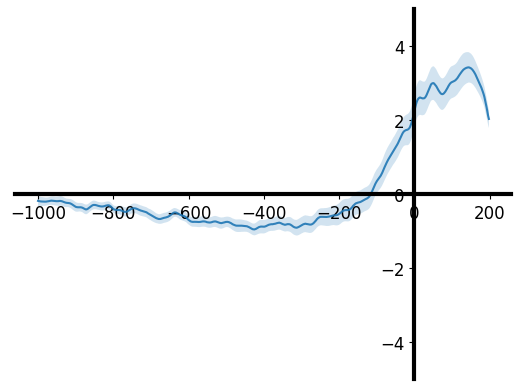

In [46]:
times = np.arange(-1000, 200, 1200/601)
plot_erp_results(test_plot, times, ylim=[-5,5],labelpad=25)